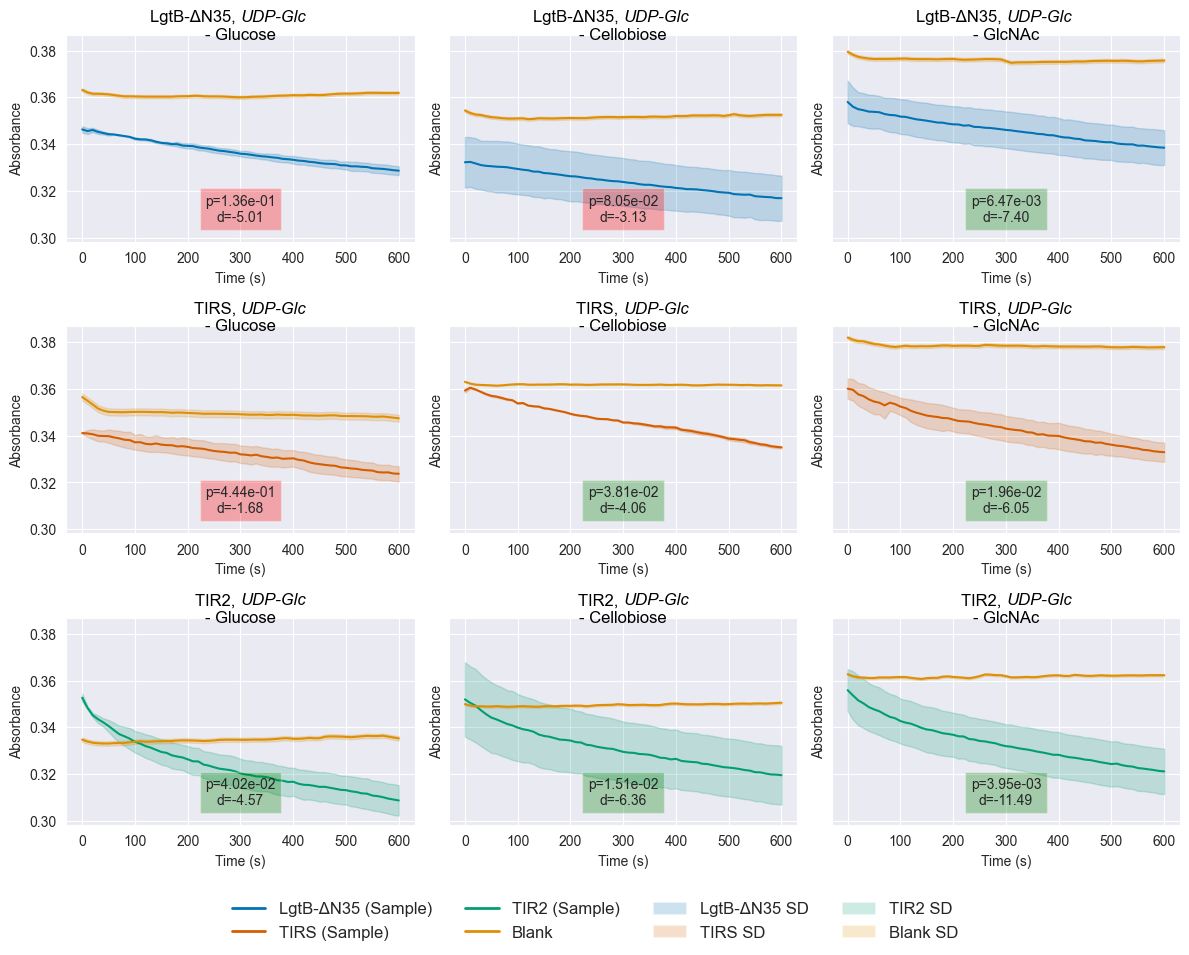

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import ttest_rel
from scipy.interpolate import interp1d

# Load the Excel file
file_path = r'C:\Users\[...]\X.xlsx'
xls = pd.ExcelFile(file_path)

# Use Seaborn colorblind palette
palette = sns.color_palette("colorblind", 10)
enzyme_color_map = {
    "LgtB-ΔN35": palette[0],   # blue
    "TIRS": palette[3],   # red
    "TIR2": palette[2]    # green
}
blank_color = palette[1]  # orange

# Define enzyme row indices
enzyme_rows = {
    "LgtB-ΔN35, UDP-Glc": (1, 13),
    "TIRS, UDP-Glc": (15, 27),
    "TIR2, UDP-Glc": (29, 41)
}

# Extract data from sheets
data = {}
for sheet_name in ["Glc Activity", "Glc Blanks"]:
    df = xls.parse(sheet_name, header=None)
    sheet_data = {}
    for enzyme, (start, end) in enzyme_rows.items():
        enzyme_section = df.iloc[start:end]
        time_values = enzyme_section.iloc[1, 1:].astype(float).values
        temp_values = enzyme_section.iloc[2, 1:].astype(float).values
        temp_mean = np.mean(temp_values)

        substrates = {}
        i = 4
        while i < len(enzyme_section):
            if pd.notna(enzyme_section.iloc[i, 0]):
                substrate = enzyme_section.iloc[i, 0]
                values = []
                while i < len(enzyme_section) and enzyme_section.iloc[i, 0] == substrate:
                    values.append(enzyme_section.iloc[i, 1:].astype(float).values)
                    i += 1
                substrates[substrate] = np.asarray(values)
            else:
                i += 1

        sheet_data[enzyme] = {"time": time_values, "temp": temp_mean, "substrates": substrates}
    data[sheet_name] = sheet_data

# --- Time course plots ---
fig, axes = plt.subplots(len(enzyme_rows), 3, figsize=(12, 10), sharey=True)

for row_idx, enzyme in enumerate(enzyme_rows.keys()):
    enzyme_key = enzyme.split(',')[0]
    enzyme_color = enzyme_color_map.get(enzyme_key, 'blue')

    for col_idx, substrate in enumerate(["Glucose", "Cellobiose", "GlcNAc"]):
        ax = axes[row_idx, col_idx]

        activity = data["Glc Activity"][enzyme]["substrates"][substrate]
        blanks = data["Glc Blanks"][enzyme]["substrates"][substrate]
        activity_time = data["Glc Activity"][enzyme]["time"]
        blanks_time = data["Glc Blanks"][enzyme]["time"]

        interp_func = interp1d(blanks_time, blanks.mean(axis=0), kind='linear', fill_value='extrapolate')
        blanks_interp = interp_func(activity_time)

        # Compute replicate-wise deltas
        activity_deltas = activity[:, -1] - activity[:, 0]
        blank_deltas = blanks[:, -1] - blanks[:, 0]

        # Perform paired t-test
        p_value = ttest_rel(activity_deltas, blank_deltas).pvalue
        significant = p_value < 0.05

        # Compute Cohen’s d from replicate deltas
        mean_diff = np.mean(activity_deltas) - np.mean(blank_deltas)
        pooled_std = np.sqrt((np.std(activity_deltas, ddof=1)**2 + np.std(blank_deltas, ddof=1)**2) / 2)
        effect_size = mean_diff / pooled_std

        # Plot activity and blanks with SD
        ax.plot(activity_time, activity.mean(axis=0), color=enzyme_color)
        ax.plot(activity_time, blanks_interp, color=blank_color)
        ax.fill_between(activity_time, activity.mean(axis=0) - activity.std(axis=0),
                        activity.mean(axis=0) + activity.std(axis=0), color=enzyme_color, alpha=0.2)
        ax.fill_between(activity_time, blanks_interp - np.std(blanks_interp),
                        blanks_interp + np.std(blanks_interp), color=blank_color, alpha=0.2)

        # p-value box
        color = "green" if significant else "red"
        ax.text(0.5, 0.1, f"p={p_value:.2e}\nd={effect_size:.2f}",
                transform=ax.transAxes, fontsize=10, ha='center', bbox=dict(facecolor=color, alpha=0.3))

        # Title with italic UDP-Glc
        enzyme_parts = enzyme.split("UDP-Glc")
        title_x = 0.5
        title_y = 1.05
        ax.set_title("")
        ax.text(title_x, title_y, enzyme_parts[0], transform=ax.transAxes,
                ha='right', va='bottom', fontsize=12, color='black')
        ax.text(title_x, title_y, "UDP-Glc", transform=ax.transAxes,
                ha='left', va='bottom', fontsize=12, color='black', style='italic')
        ax.text(title_x, title_y - 0.07, f"- {substrate}", transform=ax.transAxes,
                ha='center', fontsize=12, color='black')

        ax.set_xlabel("Time (s)")
        ax.set_ylabel("Absorbance")

# Add legend
legend_handles = [
    plt.Line2D([0], [0], color=palette[0], label='LgtB-ΔN35 (Sample)', linewidth=2),
    plt.Line2D([0], [0], color=palette[3], label='TIRS (Sample)', linewidth=2),
    plt.Line2D([0], [0], color=palette[2], label='TIR2 (Sample)', linewidth=2),
    plt.Line2D([0], [0], color=blank_color, label='Blank', linewidth=2),
    plt.Rectangle((0, 0), 1, 1, fc=palette[0], alpha=0.2, label='LgtB-ΔN35 SD'),
    plt.Rectangle((0, 0), 1, 1, fc=palette[3], alpha=0.2, label='TIRS SD'),
    plt.Rectangle((0, 0), 1, 1, fc=palette[2], alpha=0.2, label='TIR2 SD'),
    plt.Rectangle((0, 0), 1, 1, fc=blank_color, alpha=0.2, label='Blank SD')
]
fig.legend(handles=legend_handles, loc='lower center', ncol=4, fontsize=12, frameon=False)

plt.tight_layout(rect=[0, 0.07, 1, 0.96])
plt.show()

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_174800\249788547.py:75: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=x_labels, y=percent_changes, palette=colors)


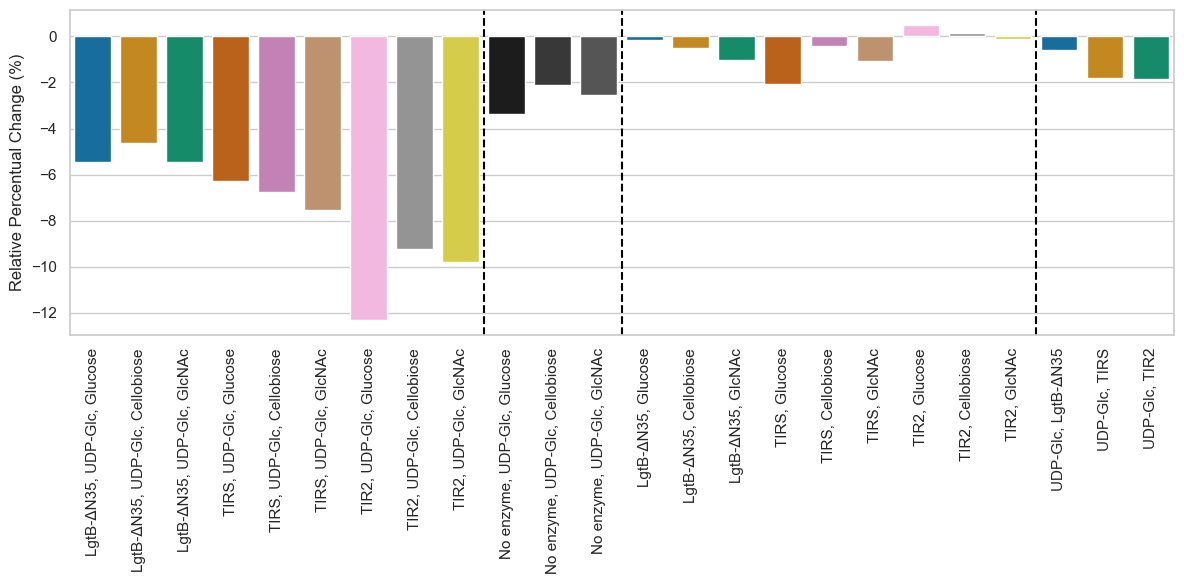

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def process_and_plot():
    # Load the Excel file
    file_path = r'C:\Users\[...]\X.xlsx'
    df = pd.read_excel(file_path, sheet_name="Glc Change", header=None)

    # Define groups with correct row indexing
    groups = {
        "Group 1": (1, 10, 0),  # Rows 1-10, Labels in row 1
        "Group 2": (12, 21, 11), # Rows 12-21, Labels in row 12
        "Group 3": (23, 32, 22),  # Rows 23-32, Labels in row 23
        "Group 4": (34, 43, 33)  # Rows 34-43, Labels in row 34
    }

    # Initialize lists
    x_labels = []
    percent_changes = []
    group_assignments = []

    # Iterate through groups
    for group_index, (group_name, (start, end, label_row)) in enumerate(groups.items()):
        measurement_labels = df.iloc[label_row, :].dropna().values  # Extract measurement labels

        for i in range(4):  # Iterate over 4 sets of columns (1-3, 4-6, 7-9, 10-12)
            name_col = i * 3
            before_col = name_col + 1
            after_col = name_col + 2

            if after_col >= df.shape[1]:  # Ensure columns exist
                continue

            sub_df = df.iloc[start:end+1, [name_col, before_col, after_col]].dropna()

            for name in sub_df.iloc[:, 0].unique():
                subset = sub_df[sub_df.iloc[:, 0] == name]
                if len(subset) >= 3:
                    mean_before = subset.iloc[:, 1].mean()
                    mean_after = subset.iloc[:, 2].mean()
                    percent_change = ((mean_after - mean_before) / mean_before) * 100

                    x_labels.append(f"{measurement_labels[i]}, {name}")
                    percent_changes.append(percent_change)
                    group_assignments.append(group_index)

    # Define color palette
    palette = sns.color_palette("colorblind", 10)
    grey_palette = sns.color_palette("gray", len(percent_changes) // 3)  # Greys for Group 2

    # Assign colors with consistent order for Group 1 and Group 3
    color_map = {}  # To store color mappings for consistent ordering
    colors = []
    color_index = 0
    group1_colors = []

    for index, label in zip(group_assignments, x_labels):
        if index == 1:  # Group 2 -> use grey tones
            colors.append(grey_palette.pop(0))
        else:  # Group 1 and 3 -> use the same colorblind palette in the same order
            if index == 0:  # Store colors for Group 1
                color = palette[color_index % len(palette)]
                color_map[label] = color
                group1_colors.append(color)
            else:  # Group 3 should follow the same order as Group 1
                color = group1_colors[color_index % len(group1_colors)]
            colors.append(color)
            color_index += 1

    # Plot results
    sns.set(style="whitegrid")

    plt.figure(figsize=(12, 6))
    ax = sns.barplot(x=x_labels, y=percent_changes, palette=colors)

    # Add vertical lines to separate groups
    group_boundaries = [9, 12, 21]  # Vertical lines between bar 9 & 10 and 12 & 13
    for boundary in group_boundaries:
        plt.axvline(x=boundary - 0.5, color='black', linestyle='--')

    plt.xticks(rotation=90)
    plt.ylabel("Relative Percentual Change (%)")
    plt.tight_layout()
    plt.show()

# Run the function
process_and_plot()



Sheets in the file: ['Activity', 'No enzyme', 'Blanks', 'Change', 'Glc Activity', 'Glc No enzyme', 'Glc Blanks', 'Glc Blank No acceptor', 'Glc Change']
Processing sheet: Glc No enzyme
Processing sheet: Glc Blank No acceptor


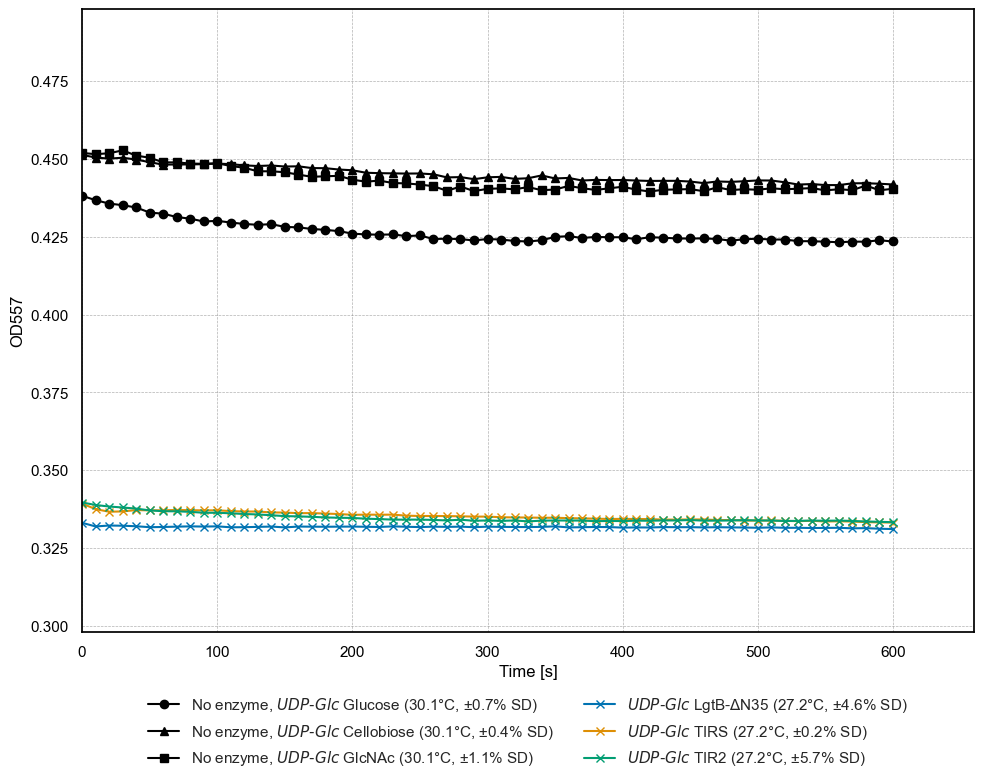

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Load the Excel file
file_path = r'C:\Users\[...]\X.xlsx'
xls = pd.ExcelFile(file_path)

# Use Seaborn colorblind palette
palette = sns.color_palette("colorblind", 10)

# Define markers for substrates, including "LgtB", "TIRS", and "TIR2"
substrate_markers = {
    "Glucose": "o",      # Circle
    "Cellobiose": "^",   # Triangle
    "GlcNAc": "s"        # Square
}

# Define color mappings for specific substrates using "colorblind" palette
substrate_colors = {
    "LgtB-ΔN35": palette[0],  # Blue
    "TIRS": palette[1],  # Red
    "TIR2": palette[2]   # Green
}

# Define y-axis limits for specific sheets
y_axis_limits = {
    "Glc Activity": (0.28, 0.40),
    "Glc No enzyme": (0.38, 0.48),
    "Glc Blanks": (0.32, 0.40),
    "Glc Blank No acceptor": (0.32, 0.40)
}

# Check available sheets
print("Sheets in the file:", xls.sheet_names)

# Create figure
fig, ax = plt.subplots(figsize=(10, 8), facecolor='white')
ax.set_facecolor('white')  # Set axes (plot area) background to white
ax.spines['top'].set_color('black')
ax.spines['right'].set_color('black')
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_color('black')
ax.tick_params(colors='black')  # Set tick colors
ax.set_xlabel("Time [s]", color='black')
ax.set_ylabel("OD557", color='black')

# Enable grid with grey lines
ax.grid(True, which='both', linestyle='--', linewidth=0.5, color='gray', alpha=0.6)

# Initialize global axis limits
global_x_min = float('inf')
global_x_max = float('-inf')
global_y_min = float('inf')
global_y_max = float('-inf')

# Sheets to plot
sheet_names_to_plot = ["Glc No enzyme", "Glc Blank No acceptor"]

# Keep track of legend entries
legend_handles = []
legend_labels = []

for sheet_name in sheet_names_to_plot:
    print(f"Processing sheet: {sheet_name}")
    df = xls.parse(sheet_name, header=None)
    if df.empty:
        print(f"Warning: Sheet {sheet_name} is empty.")
        continue

    color_counter = 0
    custom_colors = ['black'] * len(palette)  # For no enzyme / blank

    i = 0
    while i < len(df):
        if pd.notna(df.iloc[i, 0]) and df.iloc[i, 0] not in ["Cycle Nr.", "Time [s]", "Temp. [°C]"]:
            enzyme = df.iloc[i, 0]
            enzyme_color = custom_colors[color_counter % len(custom_colors)]
            color_counter += 1

            time_values = df.iloc[i + 2, 1:].astype(float).values
            temp_mean = df.iloc[i + 3, 1:].astype(float).mean()

            i += 4
            while i < len(df) and pd.notna(df.iloc[i, 0]):
                substrate = df.iloc[i, 0]
                values = []

                while i < len(df) and df.iloc[i, 0] == substrate:
                    values.append(df.iloc[i, 1:].astype(float).values)
                    i += 1

                values = np.asarray(values, dtype=float)
                mean_values = values.mean(axis=0)
                std_values = values.std(axis=0)
                std_percentage = (std_values / mean_values) * 100
                avg_std_percentage = std_percentage.mean()

                substrate_color = substrate_colors.get(substrate, enzyme_color)
                marker = substrate_markers.get(substrate, "x")

                line, = ax.plot(time_values, mean_values,
                                color=substrate_color,
                                marker=marker,
                                linestyle='-')

                # Format label with italic UDP-Glc if present
                label = f"{enzyme} {substrate} ({temp_mean:.1f}°C, ±{avg_std_percentage:.1f}% SD)"
                label = label.replace("UDP-Glc", r"$\it{UDP\text{-}Glc}$")

                legend_handles.append(line)
                legend_labels.append(label)

                global_x_min = min(global_x_min, time_values.min())
                global_x_max = max(global_x_max, time_values.max())
                global_y_min = min(global_y_min, mean_values.min())
                global_y_max = max(global_y_max, mean_values.max())
        else:
            i += 1

# Set axis limits with padding
ax.set_xlim(left=global_x_min * 0.9, right=global_x_max * 1.1)
ax.set_ylim(bottom=global_y_min * 0.9, top=global_y_max * 1.1)

# Restore normal legend formatting, now with italic UDP-Glc
ax.legend(legend_handles, legend_labels, loc='upper center', bbox_to_anchor=(0.5, -0.08), ncol=2, frameon=False)

plt.tight_layout()
plt.show()


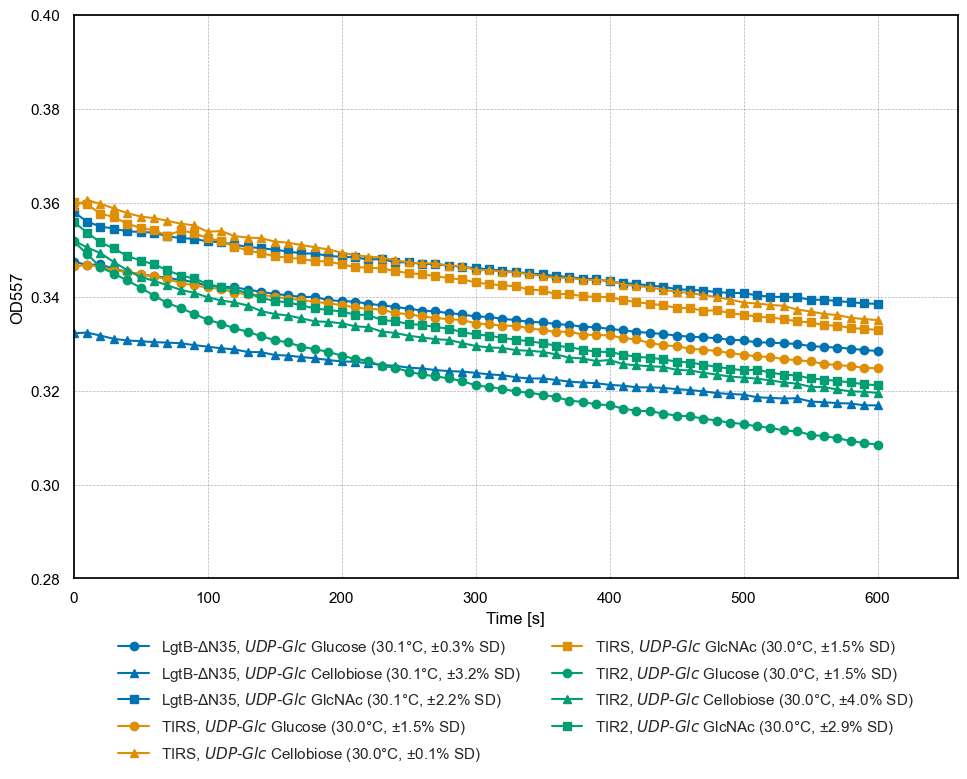

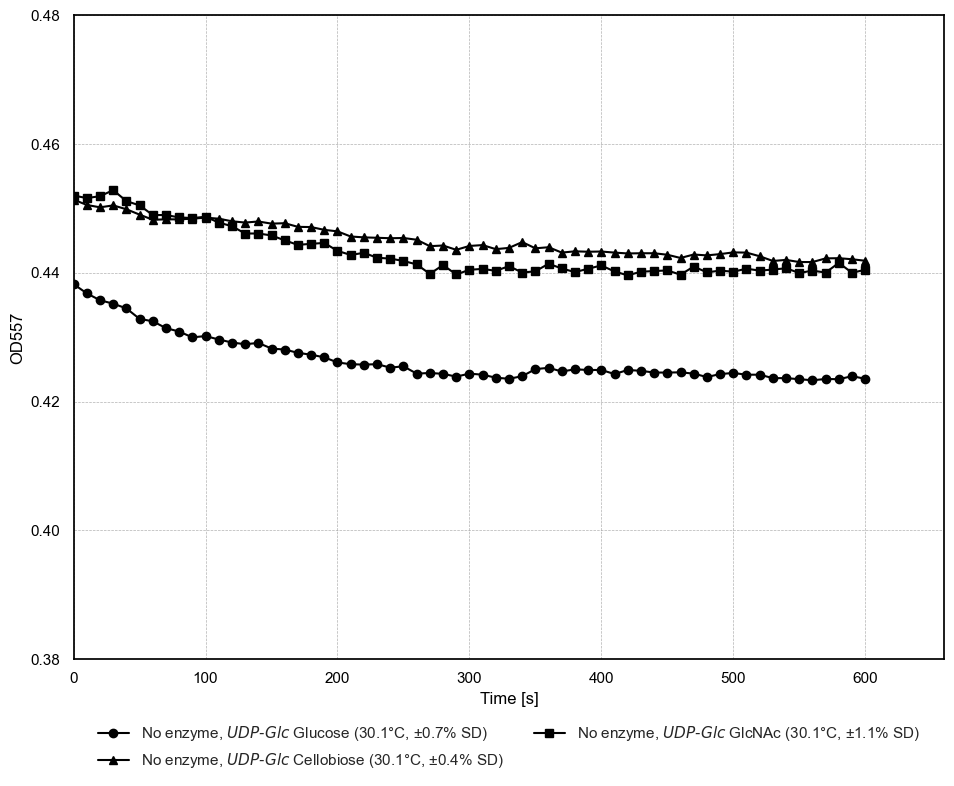

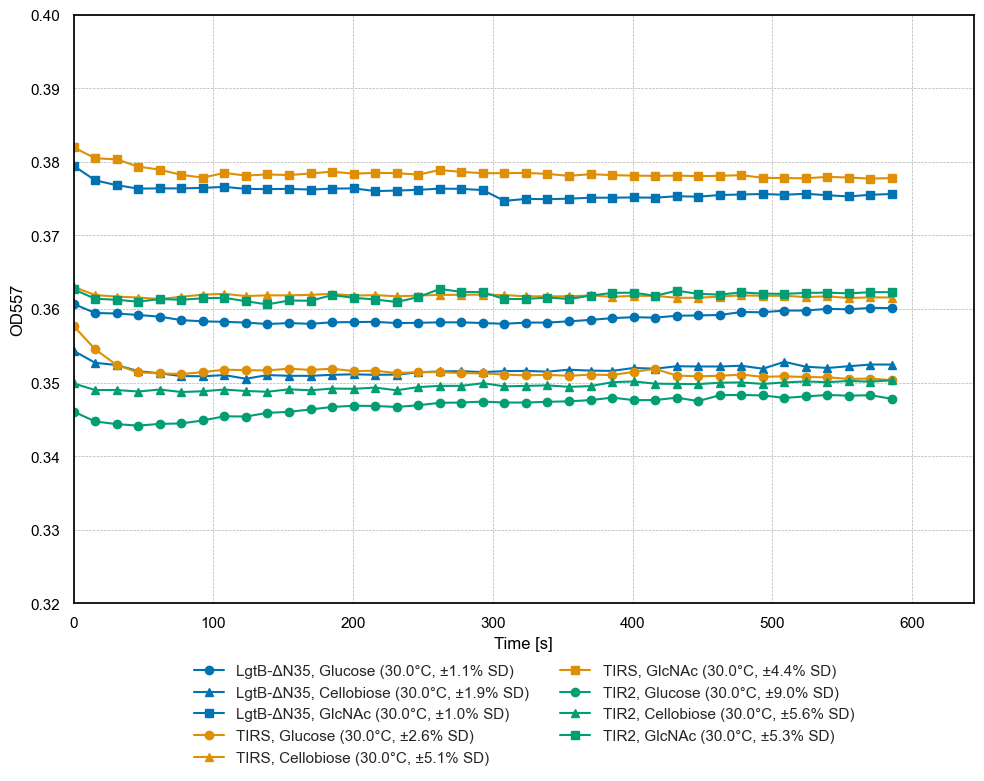

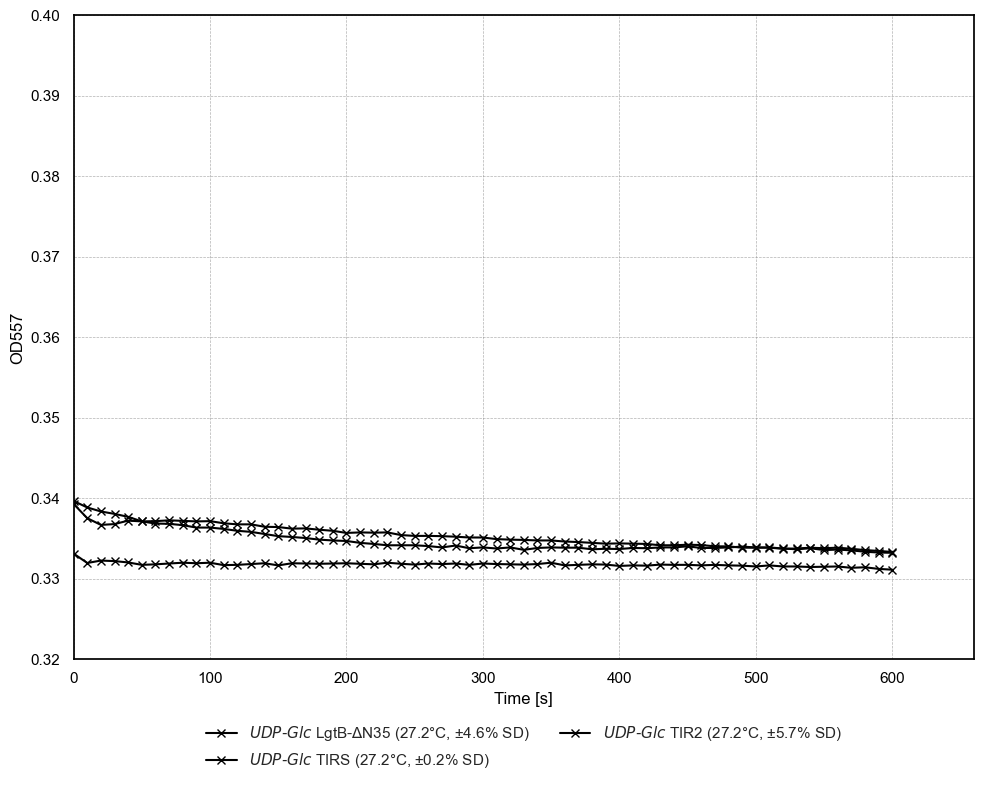

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Load the Excel file
file_path = r'C:\Users\[...]\X.xlsx'
xls = pd.ExcelFile(file_path)

# Use Seaborn colorblind palette
palette = sns.color_palette("colorblind", 10)

# Define markers for substrates
substrate_markers = {
    "Glucose": "o",      # Circle
    "Cellobiose": "^",   # Triangle
    "GlcNAc": "s"        # Square
}

# Define y-axis limits
y_axis_limits = {
    "Glc Activity": (0.28, 0.40),
    "Glc No enzyme": (0.38, 0.48),
    "Glc Blanks": (0.32, 0.40),
    "Glc Blank No acceptor": (0.32, 0.40)
}

# Loop through the sheets
for sheet_name in xls.sheet_names:
    if sheet_name not in y_axis_limits:
        continue  # Skip irrelevant sheets

    df = xls.parse(sheet_name, header=None)

    # Create figure with white background
    fig = plt.figure(figsize=(10, 8), facecolor='white')
    ax = plt.gca()
    ax.set_facecolor('white')  # Set axes (plot area) background to white
    ax.spines['top'].set_color('black')
    ax.spines['right'].set_color('black')
    ax.spines['bottom'].set_color('black')
    ax.spines['left'].set_color('black')
    ax.tick_params(colors='black')  # Set tick colors
    plt.xlabel("Time [s]", color='black')
    plt.ylabel("OD557", color='black')
    plt.grid(True, which='both', linestyle='--', linewidth=0.5, color='gray', alpha=0.6)  # Grey gridlines

    color_counter = 0
    custom_colors = palette.copy()

    if sheet_name in ["Glc No enzyme", "Glc Blank No acceptor"]:
        custom_colors = ['black'] * len(custom_colors)

    if sheet_name == "Glc Activity" and len(custom_colors) > 3:
        custom_colors[3] = (0.3, 0.8, 0.3)

    i = 0
    while i < len(df):
        if pd.notna(df.iloc[i, 0]) and df.iloc[i, 0] not in ["Cycle Nr.", "Time [s]", "Temp. [°C]"]:
            enzyme = df.iloc[i, 0]
            enzyme_color = custom_colors[color_counter % len(custom_colors)]
            color_counter += 1

            time_values = df.iloc[i + 2, 1:].astype(float).values
            temp_mean = df.iloc[i + 3, 1:].astype(float).mean()
            i += 4

            while i < len(df) and pd.notna(df.iloc[i, 0]):
                substrate = df.iloc[i, 0]
                values = []

                while i < len(df) and df.iloc[i, 0] == substrate:
                    values.append(df.iloc[i, 1:].astype(float).values)
                    i += 1

                values = np.asarray(values, dtype=float)
                mean_values = values.mean(axis=0)
                std_values = values.std(axis=0)
                std_percentage = (std_values / mean_values) * 100
                avg_std_percentage = std_percentage.mean()

                label = f"{enzyme} {substrate} ({temp_mean:.1f}°C, ±{avg_std_percentage:.1f}% SD)"
                label = label.replace("UDP-Glc", r"$\it{UDP\text{-}Glc}$")

                plt.plot(time_values, mean_values,
                         label=label,
                         color=enzyme_color,
                         marker=substrate_markers.get(substrate, "x"),
                         linestyle='-')
        else:
            i += 1

    # Axis limits
    if sheet_name == "Glc Activity":
        plt.xlim(left=0, right=600 * 1.1)
    else:
        plt.xlim(left=0, right=max(time_values) * 1.1)

    if sheet_name in y_axis_limits:
        plt.ylim(y_axis_limits[sheet_name])

    # Legend with white background
    legend = plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.08), ncol=2, frameon=False)
    legend.get_frame().set_facecolor('white')

    plt.tight_layout()
    plt.show()



